In [ ]:
pip install bilby

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install bilby_pipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
%cd 5132@

[Errno 2] No such file or directory: '5132@'
/content/gdrive/MyDrive


In [ ]:
%cd 5132

/content/gdrive/MyDrive/5132


In [ ]:
!bilby_pipe_create_injection_file injection.prior --n-injection 100 --generation-seed 1234 -f injection.dat

17:17 bilby_pipe INFO    : Setting prior-file to injection.prior
17:17 bilby_pipe INFO    : Setting trigger time 0.0
17:17 bilby_pipe INFO    : Setting segment duration 4s
17:17 bilby_pipe WARNING :  Argument detectors contains "" not in the known detectors list: ['CE', 'ET', 'V1', 'L1', 'A1', 'GEO600', 'K1', 'H1'] . This will likely fail at the data generation step 
17:17 bilby_pipe INFO    : Generating injection file injection.dat from prior=injection.prior, n_injection=100, generation_seed=1234
17:17 bilby_pipe INFO    : Created injection file injection.dat


In [ ]:
!bilby_pipe_create_injection_file injection2.prior --n-injection 1 --generation-seed 1234 -f injection2.dat

17:17 bilby_pipe INFO    : Setting prior-file to injection2.prior
17:17 bilby_pipe INFO    : Setting trigger time 0.0
17:17 bilby_pipe INFO    : Setting segment duration 4s
17:17 bilby_pipe WARNING :  Argument detectors contains "" not in the known detectors list: ['CE', 'ET', 'V1', 'L1', 'A1', 'GEO600', 'K1', 'H1'] . This will likely fail at the data generation step 
17:17 bilby_pipe INFO    : Generating injection file injection2.dat from prior=injection2.prior, n_injection=1, generation_seed=1234
17:17 bilby_pipe INFO    : Created injection file injection2.dat


In [ ]:
!lalapps_chirplen --m1 10.3 --m2 20.8  --flow 20

0: Reached requested termination frequency
fStart according to Tev = 1.999998e+01 Hz
fStop  according to Tev = 1.411041e+02 Hz
length according to Tev = 3.199133e+00 seconds
Ncycle according to Tev = 97.335353 


In [ ]:
filename = "injection3.dat"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_neutron_star_parameters, generate_all_bns_parameters

In [ ]:
class InjectionRun:
  def __init__(self):

    ###############################################
    # Code in case you want to import your own dat
    # file to use in this code. This is not used now

    # fn stores the filename of the dat file

    # In the case of multiple lines in the dat file
    # num is the index of the current row

    # I am not sure how the code would run for multiple lines of priors
    # Regardless, that is not something any computer available to us 
    # would be able to handle

    ###############################################

    
    #import pandas as pd
    #df = pd.read_csv(fn, sep=" ")
    #self.mass_1 = df["mass_1"][num]
    #self.mass_2 = df["mass_2"][num]
    #self.a_1 = df["a_1"][num]
    #self.a_2 = df["a_2"][num]
    #self.tilt_1 = df["tilt_1"][num]
    #self.tilt_2 = df["tilt_2"][num]
    #self.phi_12 = df["phi_12"][num]
    #self.phi_jl = df["phi_jl"][num]
    #self.dec = df["dec"][num]
    #self.ra = df["ra"][num]
    #self.theta_jn = df["theta_jn"][num]
    #self.psi = df["psi"][num]
    #self.phase = df["phase"][num]
    #self.geocent_time = df["geocent_time"][num]
    #self.chirp_mass = (self.mass_1*self.mass_2)**(3/5) / (self.mass_1+self.mass_2)**(1/5)
    #self.mass_ratio = min(self.mass_1, self.mass_2)/max(self.mass_1, self.mass_2)
    #self.luminosity_distance = df["luminosity_distance"][num]
    
    
    #################################################
    # Data for GW170817

    # References:
    #   -> https://github.com/mattpitkin/gw_notebooks/blob/master/EstimateDistance.ipynb

    #################################################
    
    self.mass_1=1.46                  # Studies have brought down the estimates to 1.46 +- 0.12
    self.mass_2=1.27                  # and 1.27 +- 0.09. We could use a uniform distribution 
                                      # across these ranges for a more correct estimate.
    self.a_1=0.264813928565
    self.a_2=0.702414508316
    self.tilt_1=2.58869030589
    self.tilt_2=0.948965945788
    self.phi_12= 6.04852924541
    self.phi_jl=4.81306908412

    self.luminosity_distance=40       # We want a better estimate of luminosity distance.
                                      # Current estimates are 26-48 Mpc.

    self.theta_jn=2.74719229269       # There is some degeneracy between inlcination angle 
                                      # theta jnand luminosity distance. However, we were
                                      # able to isolate the inclination angle due to the presence
                                      # of an EM counterpart

    self.psi=2.85798614041816    
    self.phase=2.371341   

    self.geocent_time=1187008882.43   # There is some time delay between the GW reaching H1 and 
                                      # L1 detectors. However it is small so I shall account for
                                      # this in future versions.
    self.ra=3.44615261
    self.dec= -0.408082219800

    self.lambda_1 = 590.7203176488288 # 565.668993742142 -> 617.6943629446084
    self.lambda_2 = 279.3840526017914 # 262.95917456078166 -> 292.1087835624852

  #####################################################
  # To get the dictionary of injected values
  #####################################################
  def getDict(self):
    irdict = dict(
      mass_1=self.mass_1, mass_2=self.mass_2, a_1=self.a_1, a_2=self.a_2, tilt_1=self.tilt_1, tilt_2=self.tilt_2, 
      phi_12=self.phi_12, phi_jl=self.phi_jl, theta_jn=self.theta_jn, psi=self.psi,
      phase=self.phase, geocent_time=self.geocent_time, ra=self.ra, dec=self.dec, luminosity_distance = self.luminosity_distance)
    return(irdict)

  ####################################################
  # Calculates results, stores them in outdir, short.
  # Returns result and posterior for luminosity distance
  # Takes input nl for nlive. Larger nlive means better
  # estimate but takes longer to run. nl = 5 took 45 mins
  ####################################################
  def getResult(self, nl):
    import numpy as np
    import matplotlib.pyplot as plt
    import bilby
    from bilby.core.prior import Uniform
    from bilby.gw.conversion import convert_to_lal_binary_neutron_star_parameters, generate_all_bns_parameters

    np.random.seed(1234) # For reproducibility

    injection_parameters = self.getDict()

    waveform_arguments = dict(waveform_approximant='SpinTaylorT4',
                                  reference_frequency=50., minimum_frequency=20., catch_waveform_errors=True)

    # IMRPhenom_NRTidal is significantly slower than IMRPhenomPv2 

    duration = 185.25
    sampling_frequency = 2048.

    waveform_generator = bilby.gw.WaveformGenerator(
            duration=duration, sampling_frequency=sampling_frequency,
                frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                        waveform_arguments=waveform_arguments)

    ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
    ifos.set_strain_data_from_power_spectral_densities(
            sampling_frequency=sampling_frequency, duration=duration,
                start_time=injection_parameters['geocent_time'] - 3)
    injection = ifos.inject_signal(
            waveform_generator=waveform_generator,
                parameters=injection_parameters)

    H1 = ifos[0]
    H1_injection = injection[0]

    prior = bilby.core.prior.PriorDict()

    prior['luminosity_distance'] = Uniform(name='luminosity_distance', minimum=26,maximum=48)

    for key in ["mass_1", "mass_2", 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra', 'dec', 'theta_jn', 'phase', 'geocent_time']:
        prior[key] = injection_parameters[key]
    prior

    #prior["mass_1"] = Uniform(name="mass_1", minimum = 1.36, maximum = 1.58)
    #prior["mass_2"] = Uniform(name = "mass_2", minimum = 1.18, maximum = 1.36)
    prior["psi"] = Uniform(name = "psi", minimum = 2.8464217993353, maximum = 2.866418390430222, boundary = "periodic")
    prior["phase"] = Uniform(name = "phase", minimum=1.873892, maximum = 2.887066)
    #prior["lambda_1"] = Uniform(name = "lambda_1", minimum = 565.668993742142, maximum = 617.6943629446084)
    #prior["lambda_2"] = Uniform(name = "lambda_2", minimum = 262.95917456078166, maximum = 292.1087835624852)

    likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
            interferometers=ifos, waveform_generator=waveform_generator, priors=prior,
                time_marginalization=False, phase_marginalization=False, distance_marginalization=False)

    result_short = bilby.run_sampler(
            likelihood, prior, sampler='dynesty', outdir='shortspintaylor_varypsiphaselambda', label="GW170817",
                conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
                    nlive=nl, dlogz=3,  # Remove arguments in future versions (or on a better computer)
                        clean=True
                        )


    result_short.posterior
    result_short.posterior["luminosity_distance"]
    Mc = result_short.posterior["luminosity_distance"].values

    lower_bound = np.quantile(Mc, 0.05)
    upper_bound = np.quantile(Mc, 0.95)
    median = np.quantile(Mc, 0.5)
    print("Luminosity Distance = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

    fig, ax = plt.subplots()
    ax.hist(result_short.posterior["luminosity_distance"], bins=20)
    ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
    ax.axvline(median, color='C1')
    ax.set_xlabel("Luminosity Distance")
    plt.show()

    #result_short.plot_corner(parameters=["luminosity_distance", "geocent_time"], prior=True)

    result_short.priors

    result_short.sampler_kwargs["nlive"]

    print("ln Bayes factor = {} +/- {}".format(
        result_short.log_bayes_factor, result_short.log_evidence_err))

    return result_short, Mc

18:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
18:15 bilby INFO    : Injected signal in H1:
18:15 bilby INFO    :   optimal SNR = 69.09
18:15 bilby INFO    :   matched filter SNR = 69.12-0.64j
18:15 bilby INFO    :   mass_1 = 1.46
18:15 bilby INFO    :   mass_2 = 1.27
18:15 bilby INFO    :   a_1 = 0.264813928565
18:15 bilby INFO    :   a_2 = 0.702414508316
18:15 bilby INFO    :   tilt_1 = 2.58869030589
18:15 bilby INFO    :   tilt_2 = 0.948965945788
18:15 bilby INFO    :   phi_12 = 6.04852924541
18:15 bilby INFO    :   phi_jl = 4.81306908412
18:15 bilby INFO    :   theta_jn = 2.74719229269
18:15 bilby INFO    :   psi = 2.85798614041816
18:15 bilby INFO    :   phase = 2.371341
18:15 bilby INFO    :   geocent_time = 1187008882.43
18:15 bilby INFO    :   ra = 3.44615261
18:15 bilby INFO 

0it [00:00, ?it/s]

18:16 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 5, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 3, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f15da558190>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
18:16 bilby INFO    : Checkpoint every check_point_delta_t = 600s
18:16 bilby INFO    : Using dynesty version 1.0.1
18:16 bilby INFO    : Using the bilby-imp

  0%|          | 0/40 [00:00<?, ?it/s]

19:09 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/40 [00:00<?, ?it/s]

19:09 bilby INFO    : Summary of results:
nsamples: 40
ln_noise_evidence: -376743.359
ln_evidence: -372665.227 +/-  1.475
ln_bayes_factor: 4078.132 +/-  1.475



Luminosity Distance = 39.60865862813535 with a 90% C.I = 39.19762334033041 -> 40.77302605400264


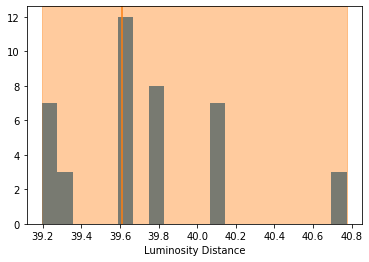

ln Bayes factor = 4078.1323006062125 +/- 1.4751233589946229


In [ ]:
ir = InjectionRun()
result, Mc = ir.getResult(5)

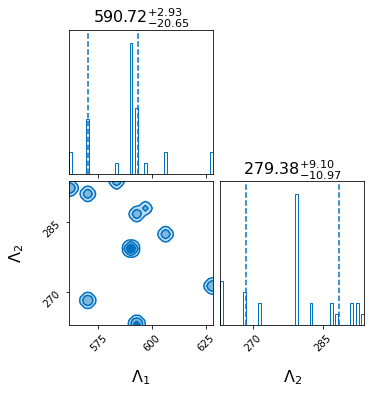

In [ ]:
result_short.plot_corner()

10:25 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
10:25 bilby INFO    : Injected signal in H1:
10:25 bilby INFO    :   optimal SNR = 66.91
10:25 bilby INFO    :   matched filter SNR = 66.27-0.03j
10:25 bilby INFO    :   mass_1 = 1.46
10:25 bilby INFO    :   mass_2 = 1.27
10:25 bilby INFO    :   a_1 = 0.264813928565
10:25 bilby INFO    :   a_2 = 0.702414508316
10:25 bilby INFO    :   tilt_1 = 2.58869030589
10:25 bilby INFO    :   tilt_2 = 0.948965945788
10:25 bilby INFO    :   phi_12 = 6.04852924541
10:25 bilby INFO    :   phi_jl = 4.81306908412
10:25 bilby INFO    :   luminosity_distance = 40
10:25 bilby INFO    :   theta_jn = 2.74719229269
10:25 bilby INFO    :   psi = 2.4777868822727473
10:25 bilby INFO    :   phase = 1.9907400675952085
10:25 bilby INFO    :   geocent_time = 1187008882

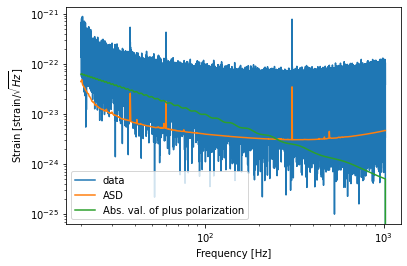

10:25 bilby INFO    : Running for label 'GW170817', output will be saved to 'short'
10:25 bilby INFO    : Using lal version 7.1.7
10:25 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.5;Id: bd2ad8ca448e9761e3010e519a656789332ea28a;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
10:25 bilby INFO    : Using lalsimulation version 3.1.2
10:25 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.5;Id: bd2ad8ca448e9761e3010e519a656789332ea28a;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
10:25 bilby INFO    : Search parameters:
10:25 bilby INFO    :   luminosity_distance = Uniform(minimum=26, maximum=48, name='luminosity_distance', latex_label='$d_L$', unit=None, boundary=None)
10:25 bilby INFO    :   psi = Uniform(minimum=0, maximum=3.141592653589793, name='psi', latex_label='$\\psi$', unit=None, boundary='periodic')
10:25 bilby INFO    :   phase = Uniform(minimum=0, maximum=6.283185307179

0it [00:00, ?it/s]

10:25 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 5, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 3, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f9052952dd0>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
10:25 bilby INFO    : Checkpoint every check_point_delta_t = 600s
10:25 bilby INFO    : Using dynesty version 1.0.1
10:25 bilby INFO    : Using the bilby-imp

  0%|          | 0/46 [00:00<?, ?it/s]

11:02 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/46 [00:00<?, ?it/s]

11:02 bilby INFO    : Summary of results:
nsamples: 46
ln_noise_evidence: -376473.683
ln_evidence: -372665.294 +/-  1.567
ln_bayes_factor: 3808.389 +/-  1.567



Luminosity Distance = 40.15271601651829 with a 90% C.I = 39.8076581689939 -> 40.4428836662342


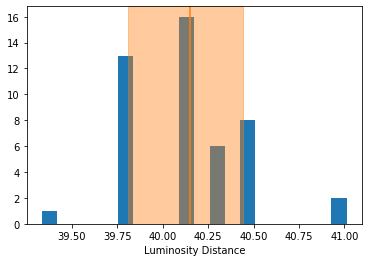

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/corner/core.py:768: UserWarning: Attempting to set identical left == right == 1187008882.43 results in singular transformations; automatically expanding.
  return ax.set_xlim(new_xlim)
/usr/local/lib/python3.7/dist-packages/corner/core.py:775: UserWarning: Attempting to set identical bottom == top == 1187008882.43 results in singular transformations; automatically expanding.
  return ax.set_ylim(new_ylim)
/usr/local/lib/python3.7/dist-packages/corner/core.py:768: UserWarning: Attempting to set identical left == right == 1.46 results in singular transformations; automatically expanding.
  return ax.set_xlim(new_xlim)
/usr/local/lib/python3.7/dist-packages/corner/core.py:768: UserWarning: Attempting to set identical left == right == 1.27 results in s

ln Bayes factor = 3808.3892988892076 +/- 1.5669923788003854


In [ ]:
# nlive = 5 run

16:40 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
16:40 bilby INFO    : Injected signal in H1:
16:40 bilby INFO    :   optimal SNR = 66.79
16:40 bilby INFO    :   matched filter SNR = 66.14+0.02j
16:40 bilby INFO    :   mass_1 = 1.46
16:40 bilby INFO    :   mass_2 = 1.27
16:40 bilby INFO    :   a_1 = 0.264813928565
16:40 bilby INFO    :   a_2 = 0.702414508316
16:40 bilby INFO    :   tilt_1 = 2.58869030589
16:40 bilby INFO    :   tilt_2 = 0.948965945788
16:40 bilby INFO    :   phi_12 = 6.04852924541
16:40 bilby INFO    :   phi_jl = 4.81306908412
16:40 bilby INFO    :   theta_jn = 2.74719229269
16:40 bilby INFO    :   psi = 2.85798614041816
16:40 bilby INFO    :   phase = 2.371341
16:40 bilby INFO    :   geocent_time = 1187008882.43
16:40 bilby INFO    :   ra = 3.44615261
16:40 bilby INFO 

0it [00:00, ?it/s]

16:40 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 5, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 3, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f15ceebda10>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
16:40 bilby INFO    : Checkpoint every check_point_delta_t = 600s
16:40 bilby INFO    : Using dynesty version 1.0.1
16:40 bilby INFO    : Using the bilby-imp

  0%|          | 0/31 [00:00<?, ?it/s]

16:55 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/31 [00:00<?, ?it/s]

16:55 bilby INFO    : Summary of results:
nsamples: 31
ln_noise_evidence: -376451.667
ln_evidence: -379715.370 +/-  1.383
ln_bayes_factor: -3263.704 +/-  1.383



Lambda 1 = 279.38405260179417 with a 90% C.I = 262.95917456078166 -> 292.1087835624852
Lambda 2 = 279.38405260179417 with a 90% C.I = 262.95917456078166 -> 292.1087835624852


TypeError: ignored

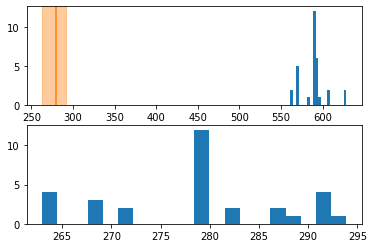

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_neutron_star_parameters, generate_all_bns_parameters

np.random.seed(1234) # For reproducibility

ir = InjectionRun()
injection_parameters = ir.getDict()

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2_NRTidal',
                                  reference_frequency=50., minimum_frequency=20., catch_waveform_errors=True)

duration = 185.25
sampling_frequency = 2048.

waveform_generator = bilby.gw.WaveformGenerator(
            duration=duration, sampling_frequency=sampling_frequency,
                frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                        waveform_arguments=waveform_arguments)

ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
            sampling_frequency=sampling_frequency, duration=duration,
                start_time=injection_parameters['geocent_time'] - 3)
injection = ifos.inject_signal(
            waveform_generator=waveform_generator,
                parameters=injection_parameters)

H1 = ifos[0]
H1_injection = injection[0]

prior = bilby.core.prior.PriorDict()

prior['luminosity_distance'] = 40.15271601651829

for key in ["mass_1", "mass_2", 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'psi', 'ra', 'dec', 'theta_jn', 'phase', 'geocent_time']:
  prior[key] = injection_parameters[key]
prior

    # Could not find data for psi and phase so we take it across all values

    # Try to get a constraint on psi. Use phase = 2.371341 and Dl = 40.15271601651929
prior["psi"] = 2.85798614041816

    # Constrain phase to 2.166 to 2.667
prior["phase"] = 2.371341

prior["lambda_1"] = Uniform(222-138, 222+420, name = "lambda_1")
prior["lambda_2"] = Uniform(222-138, 222+420, name = "lambda_2")

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
            interferometers=ifos, waveform_generator=waveform_generator, priors=prior,
                time_marginalization=False, phase_marginalization=False, distance_marginalization=False)

result_short = bilby.run_sampler(
            likelihood, prior, sampler='dynesty', outdir='shortpsiphase', label="GW170817",
                conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
                    nlive=5, dlogz=3,  # Remove arguments in future versions (or on a better computer)
                        clean=True
                        )


result_short.posterior

Mc1 = result_short.posterior["lambda_1"].values
Mc2 = result_short.posterior["lambda_2"].values

lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Lambda 1 = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

result_short.posterior["lambda_1"]
Mc2 = result_short.posterior["lambda_2"].values

lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Lambda 2 = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

fig, axs = plt.subplots(2)
axs[0].hist(result_short.posterior["lambda_1"], bins=20)
axs[1].hist(result_short.posterior["lambda_2"], bins=20)

axs[0].axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
axs[0].axvline(median, color='C1')
axs[0].set_xlabel("Lambda 1")
plt[0].show()

axs[1].axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
axs[1].axvline(median, color='C1')
axs[1].set_xlabel("Lambda 2")
plt.show()

result_short.plot_corner(parameters=["lambda_1", "lambda_2"], prior=True)

result_short.priors

result_short.sampler_kwargs["nlive"]

print("ln Bayes factor = {} +/- {}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

Lambda 1 = 590.7203176488288 with a 90% C.I = 565.6698993742142 -> 617.6943629446084
Lambda 2 = 279.38405260179417 with a 90% C.I = 262.95917456078166 -> 292.1087835624852


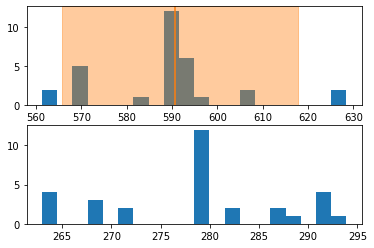

In [ ]:
Mc1 = result_short.posterior["lambda_1"].values
Mc2 = result_short.posterior["lambda_2"].values

lower_bound1 = np.quantile(Mc1, 0.05)
upper_bound1 = np.quantile(Mc1, 0.95)
median1 = np.quantile(Mc1, 0.5)
print("Lambda 1 = {} with a 90% C.I = {} -> {}".format(median1, lower_bound1, upper_bound1))

result_short.posterior["lambda_1"]
Mc2 = result_short.posterior["lambda_2"].values

lower_bound2 = np.quantile(Mc2, 0.05)
upper_bound2 = np.quantile(Mc2, 0.95)
median2 = np.quantile(Mc2, 0.5)
print("Lambda 2 = {} with a 90% C.I = {} -> {}".format(median2, lower_bound2, upper_bound2))

fig, axs = plt.subplots(2)
axs[0].hist(result_short.posterior["lambda_1"], bins=20)
axs[1].hist(result_short.posterior["lambda_2"], bins=20)

axs[0].axvspan(lower_bound1, upper_bound1, color='C1', alpha=0.4)
axs[0].axvline(median1, color='C1')
axs[0].set_xlabel("Lambda 1")
plt.show()

axs[1].axvspan(lower_bound2, upper_bound2, color='C1', alpha=0.4)
axs[1].axvline(median2, color='C1')
axs[1].set_xlabel("Lambda 2")
plt.show()